### **Axial LOB**

In [1]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 


### **Data**
The dataset used is the FI-2010 dataset.

As in the original paper I used the first 7 days to train and to validate, and the rest 3 days to do the the testing.

In [2]:
# please change the data_path to your local path and unzip the file

dec_data = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

W = 40                     #number of features
dim = 40                     #number of LOB states

horizon = 2        #if h = 5 than k = 10, h = 2 then k=50
T = 5

y_train = dec_train[-horizon, :].flatten()

y_val = dec_val[-horizon, :].flatten()
y_test = dec_test[-horizon, :].flatten()

y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print("Training data shape:", dec_train.shape)
print("Validation data shape:", dec_val.shape)
print("Testing data shape:", dec_test.shape)


Training data shape: (203800, 40)
Validation data shape: (50950, 40)
Testing data shape: (139587, 40)


In [3]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - T - self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.y[i]

In [4]:
#Hyperparameters

batch_size = 64
epochs = 1 
c_final = 4              #channel output size of the second conv
n_heads = 4
c_in_axial = 32          #channel output size of the first conv
c_out_axial = 32
pool_kernel = (1, 4)
pool_stride = (1, 4)

num_classes = 3

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

inputs, labels = next(iter(train_loader))
print("Input batch shape:", inputs.shape)
print("Label batch shape:", labels.shape)

50906
139543
203756
Input batch shape: torch.Size([64, 1, 40, 40])
Label batch shape: torch.Size([64])


### **Model Architecture**


In [5]:
import math

def _conv1d1x1(in_channels, out_channels):
  return nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                         nn.BatchNorm1d(out_channels))

#class taken from https://github.com/jeya-maria-jose/Medical-Transformer/blob/main/lib/models/axialnet.py
class GatedAxialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dim, flag):
        assert (in_channels % heads == 0) and (out_channels % heads == 0)
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dim_head_v = out_channels // heads
        self.flag = flag                #if flag then we do the attention along width
        self.dim = dim
        self.dim_head_qk = self.dim_head_v // 2
        self.qkv_channels = self.dim_head_v + self.dim_head_qk * 2

        # Multi-head self attention
        self.to_qkv = _conv1d1x1(in_channels, self.heads * self.qkv_channels)
        self.bn_qkv = nn.BatchNorm1d(self.heads * self.qkv_channels)
        self.bn_similarity = nn.BatchNorm2d(heads * 3)
        self.bn_output = nn.BatchNorm1d(self.heads * self.qkv_channels)

        # Gating mechanism
        self.f_qr = nn.Parameter(torch.tensor(0.3),  requires_grad=False) 
        self.f_kr = nn.Parameter(torch.tensor(0.3),  requires_grad=False)
        self.f_sve = nn.Parameter(torch.tensor(0.3),  requires_grad=False)
        self.f_sv = nn.Parameter(torch.tensor(0.5),  requires_grad=False)

        # Position embedding
        self.relative = nn.Parameter(torch.randn(self.dim_head_v * 2, dim * 2 - 1), requires_grad=True)
        query_index = torch.arange(dim).unsqueeze(0)
        key_index = torch.arange(dim).unsqueeze(1)
        relative_index = key_index - query_index + dim - 1
        self.register_buffer('flatten_index', relative_index.view(-1))

        self.reset_parameters()
        # self.print_para()

    def forward(self, x):
        
        if self.flag:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        x = self.to_qkv(x)
        
        qkv = self.bn_qkv(x)
        q, k, v = torch.split(qkv.reshape(N * W, self.heads, self.dim_head_v * 2, H), [self.dim_head_v // 2, self.dim_head_v // 2, self.dim_head_v], dim=2)

        # Calculate position embedding
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.dim_head_v * 2, self.dim, self.dim)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.dim_head_qk, self.dim_head_qk, self.dim_head_v], dim=0)
        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
        qk = torch.einsum('bgci, bgcj->bgij', q, k)


        # multiply by factors
        qr = torch.mul(qr, self.f_qr)
        kr = torch.mul(kr, self.f_kr)

        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.heads, H, H).sum(dim=1)
        #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
        # (N, heads, H, H, W)
        similarity = torch.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

        # multiply by factors
        sv = torch.mul(sv, self.f_sv)
        sve = torch.mul(sve, self.f_sve)

        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_channels * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_channels, 2, H).sum(dim=-2)

        if self.flag:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        return output


    def reset_parameters(self):
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.dim_head_v))


class AxialLOB(nn.Module):
    def __init__(self, W, H, c_in, c_out, c_final, n_heads, pool_kernel, pool_stride):
        super().__init__()

        """
        Args:
          W and H:  the width and height of the input tensors
          c_in, c_out, and c_final:  the number of channels for the input, intermediate, and final convolutional layers
          n_heads:  the number of heads for the multi-head attention mechanism used in the GatedAxialAttention layers.
          pool_kernel and pool_stride:  the kernel size and stride of the final average pooling layer.
        """

        #channel output of the CNN_in is the channel input for the axial layer
        self.c_in = c_in
        self.c_out = c_out
        self.c_final = c_final

        self.CNN_in = nn.Conv2d(in_channels=1, out_channels=c_in, kernel_size=1)
        self.CNN_out = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res2 = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res1 = nn.Conv2d(in_channels=1, out_channels=c_out, kernel_size=1)

        self.norm = nn.BatchNorm2d(c_in)
        self.res_norm2 = nn.BatchNorm2d(c_final)
        self.res_norm1 = nn.BatchNorm2d(c_out)
        self.norm2 = nn.BatchNorm2d(c_final)
        self.axial_height_1 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_1 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)
        self.axial_height_2 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_2 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)

        self.activation = nn.ReLU()
        self.linear = nn.Linear(1600, 3)
        self.pooling = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)

    def forward(self, x):
        
        #up branch
        #first convolution before the attention
        y = self.CNN_in(x)
        y = self.norm(y)
        y = self.activation(y)

        #attention mechanism through gated multi head axial layer
        y = self.axial_width_1(y)
        y = self.axial_height_1(y)

        #lower branch
        x = self.CNN_res1(x)
        x = self.res_norm1(x)
        x = self.activation(x)

        #first residual
        y = y + x
        z = y.detach().clone()

        #second axial layer
        y = self.axial_width_2(y)
        y = self.axial_height_2(y)
        
        #second convolution
        y = self.CNN_out(y)
        y = self.res_norm2(y)
        y = self.activation(y)

        #lower branch
        z = self.CNN_res2(z)
        z = self.norm2(z)
        z = self.activation(z)

        #second res connection
        y = y + z

        #final part
        y = self.pooling(y)
        y = torch.flatten(y, 1)
        y = self.linear(y)
        forecast_y = torch.softmax(y, dim=1)
        return forecast_y

### **Model Training**

In [6]:
axial_lob_model = AxialLOB(W, dim, c_in_axial, c_out_axial, c_final, n_heads, pool_kernel, pool_stride)
axial_lob_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(axial_lob_model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)

def batch_gd(model, criterion, optimizer, scheduler, epochs, model_name, force_save=False):
    if not force_save:
        save_path = Path(model_name)
        if save_path.exists():
            raise ValueError(
                f"{model_name} exists already. Please use a different path/name "
                    + "or set force_save=True to override the current model"
            )
            

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    for it in tqdm(range(epochs)):

        if (it == 4 and isinstance(model, AxialLOB)):
          print("Turning on additional grads for AxialLOB...")
          model.axial_height_1.f_qr.requires_grad = True
          model.axial_height_1.f_kr.requires_grad = True
          model.axial_height_1.f_sve.requires_grad = True
          model.axial_height_1.f_sv.requires_grad = True

          model.axial_width_1.f_qr.requires_grad = True
          model.axial_width_1.f_kr.requires_grad = True
          model.axial_width_1.f_sve.requires_grad = True
          model.axial_width_1.f_sv.requires_grad = True

          model.axial_height_2.f_qr.requires_grad = True
          model.axial_height_2.f_kr.requires_grad = True
          model.axial_height_2.f_sve.requires_grad = True
          model.axial_height_2.f_sv.requires_grad = True

          model.axial_width_2.f_qr.requires_grad = True
          model.axial_width_2.f_kr.requires_grad = True
          model.axial_width_2.f_sve.requires_grad = True
          model.axial_width_2.f_sv.requires_grad = True

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:

            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
           
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
    
        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        scheduler.step()
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, model_name)
            best_test_loss = test_loss
            best_test_epoch = it
            print(f'model saved at {model_name}')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
      
    return train_losses, test_losses

------- List Hyper Parameters -------
epochs   ->   1
horizon    ->     50
batch size   ->    64
Optimizer   ->    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


100%|██████████| 1/1 [05:06<00:00, 306.88s/it]

model saved at all_models/AxialLOB.pt
Epoch 1/1, Train Loss: 1.0545,           Validation Loss: 1.0211, Duration: 0:05:06.877930, Best Val Epoch: 0


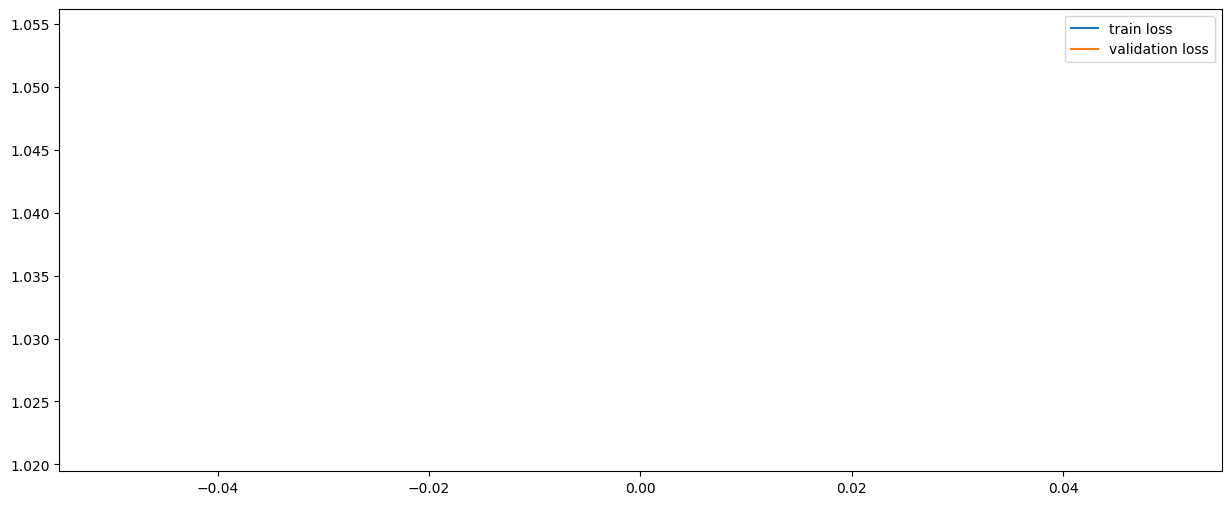

In [7]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("horizon    ->     " + str(T*10))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

# Save to the all_models directory
# If it doesn't exist, make it
save_dir = Path("all_models")
save_dir.mkdir(parents=True, exist_ok=True)
model_name = "all_models/AxialLOB.pt"
force_save = False

# If you want to start completely from scratch,
# comment out the following code and set force_save = True above
model_path = Path(model_name)
if model_path.exists():
    force_save = True
    print("Loading existing axial_lob_model...")
    axial_lob_model = torch.load(model_name).to(device)
    print("Model Loaded")

train_losses, val_losses = batch_gd(axial_lob_model, criterion, optimizer, scheduler, epochs, model_name, force_save=force_save)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

### **Model Testing**

In [8]:
axial_lob_model = torch.load(model_name).to(device)

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = axial_lob_model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)

C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\1928275702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  axial_lob_model = torch.load(model_name).to(device)


Test acc: 0.5779


              precision    recall  f1-score   support

           0     0.4579    0.3662    0.4070     38447
           1     0.7288    0.7726    0.7501     65996
           2     0.4012    0.4438    0.4214     35100

    accuracy                         0.5779    139543
   macro avg     0.5293    0.5275    0.5261    139543
weighted avg     0.5717    0.5779    0.5729    139543



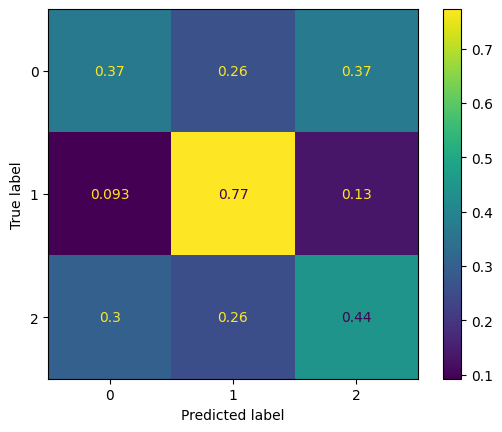

In [9]:
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

# Model Comparisons
We will now test additional models to compare their performance against AxialLOB.

In [10]:
models_to_test: dict[str, nn.Module] = {}

In [11]:
class CNN(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

models_to_test["CNN"] = CNN(W, num_classes).to(device)

In [12]:
class DeepLOB(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.lstm = nn.LSTM(W * 128, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, height, -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOB"] = DeepLOB(W, hidden_size, num_classes).to(device)

In [13]:
class B_TABL(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(W * W, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class C_TABL(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(W * W, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

models_to_test["B_TABL"] = B_TABL(W, num_classes).to(device)
models_to_test["C_TABL"] = C_TABL(W, num_classes).to(device)

In [14]:
class DeepLOBSeq2Seq(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.encoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, _, height, _ = x.size()
        x = x.view(batch_size, height, -1)  # Flatten spatial dimensions
        _, (hidden, _) = self.encoder(x)  # Encoder outputs
        x, _ = self.decoder(x)  # Decoder processes input
        x = x[:, -1, :]  # Use last time-step
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOBSeq2Seq"] = DeepLOBSeq2Seq(W, hidden_size, num_classes).to(device)

In [15]:
class DeepLOBAttention(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.encoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, _, height, _ = x.size()
        x = x.view(batch_size, height, -1)  # Flatten spatial dimensions
        x, _ = self.encoder(x)  # Encoder outputs
        attention_weights = self.attention(x)  # Compute attention weights
        x = torch.sum(attention_weights * x, dim=1)  # Apply attention
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOBAttention"] = DeepLOBAttention(W, hidden_size, num_classes).to(device)

Training CNN...


100%|██████████| 1/1 [00:07<00:00,  7.24s/it]

model saved at all_models\CNN.pt
Epoch 1/1, Train Loss: 1.0788,           Validation Loss: 1.0922, Duration: 0:00:07.239001, Best Val Epoch: 0
Evaluating CNN...



C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\25377337.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(save_path)).to(device)


              precision    recall  f1-score   support

           0     0.3301    0.4882    0.3939     38447
           1     0.5661    0.6702    0.6138     65996
           2     0.3676    0.0477    0.0845     35100

    accuracy                         0.4635    139543
   macro avg     0.4213    0.4020    0.3640    139543
weighted avg     0.4512    0.4635    0.4201    139543



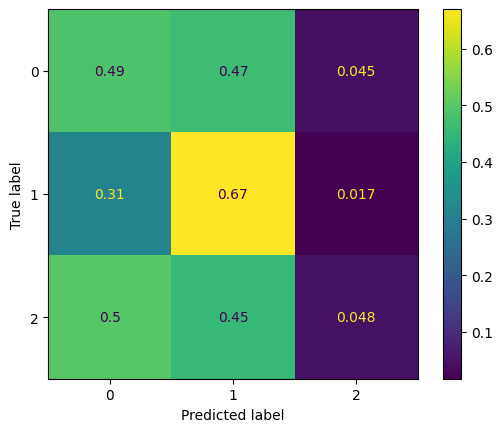

Training DeepLOB...


100%|██████████| 1/1 [00:37<00:00, 37.91s/it]

model saved at all_models\DeepLOB.pt
Epoch 1/1, Train Loss: 0.7697,           Validation Loss: 0.8497, Duration: 0:00:37.909030, Best Val Epoch: 0
Evaluating DeepLOB...



C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\25377337.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(save_path)).to(device)


              precision    recall  f1-score   support

           0     0.7826    0.5953    0.6762     38447
           1     0.7370    0.9083    0.8137     65996
           2     0.7574    0.6249    0.6848     35100

    accuracy                         0.7508    139543
   macro avg     0.7590    0.7095    0.7249    139543
weighted avg     0.7547    0.7508    0.7434    139543



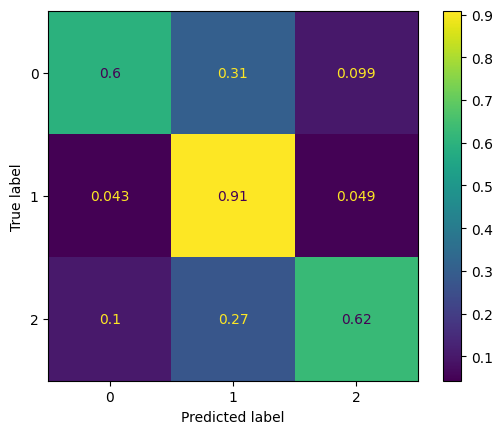

Training B_TABL...


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

model saved at all_models\B_TABL.pt
Epoch 1/1, Train Loss: 1.0156,           Validation Loss: 1.1412, Duration: 0:00:07.270997, Best Val Epoch: 0
Evaluating B_TABL...



C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\25377337.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(save_path)).to(device)


              precision    recall  f1-score   support

           0     0.4078    0.3828    0.3949     38447
           1     0.6516    0.3546    0.4593     65996
           2     0.3485    0.6706    0.4587     35100

    accuracy                         0.4418    139543
   macro avg     0.4693    0.4693    0.4376    139543
weighted avg     0.5082    0.4418    0.4414    139543



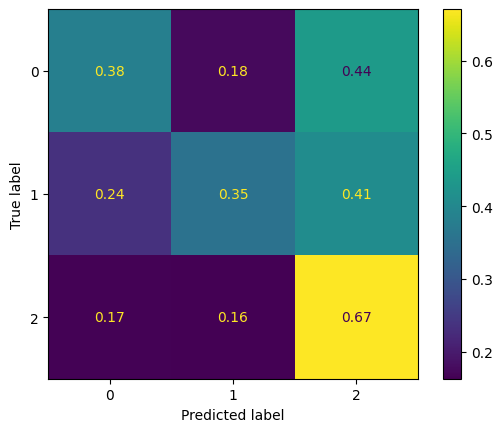

Training C_TABL...


100%|██████████| 1/1 [00:09<00:00,  9.18s/it]

model saved at all_models\C_TABL.pt
Epoch 1/1, Train Loss: 1.0065,           Validation Loss: 1.0952, Duration: 0:00:09.179278, Best Val Epoch: 0
Evaluating C_TABL...



C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\25377337.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(save_path)).to(device)


              precision    recall  f1-score   support

           0     0.4817    0.3337    0.3942     38447
           1     0.5715    0.6435    0.6054     65996
           2     0.4193    0.4611    0.4392     35100

    accuracy                         0.5123    139543
   macro avg     0.4908    0.4794    0.4796    139543
weighted avg     0.5085    0.5123    0.5054    139543



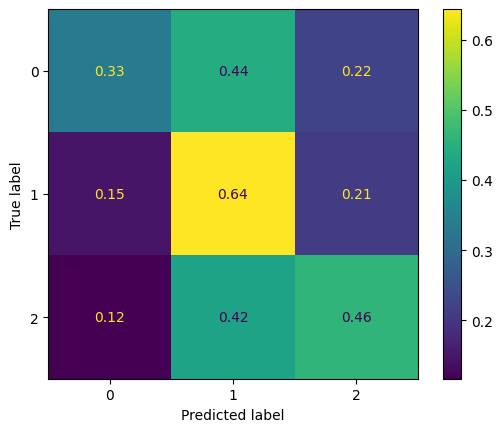

Training DeepLOBSeq2Seq...


100%|██████████| 1/1 [00:12<00:00, 12.05s/it]

model saved at all_models\DeepLOBSeq2Seq.pt
Epoch 1/1, Train Loss: 0.9385,           Validation Loss: 1.0594, Duration: 0:00:12.053786, Best Val Epoch: 0
Evaluating DeepLOBSeq2Seq...



C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\25377337.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(save_path)).to(device)


              precision    recall  f1-score   support

           0     0.6167    0.4049    0.4889     38447
           1     0.6491    0.7578    0.6993     65996
           2     0.5079    0.5390    0.5230     35100

    accuracy                         0.6056    139543
   macro avg     0.5912    0.5673    0.5704    139543
weighted avg     0.6047    0.6056    0.5970    139543



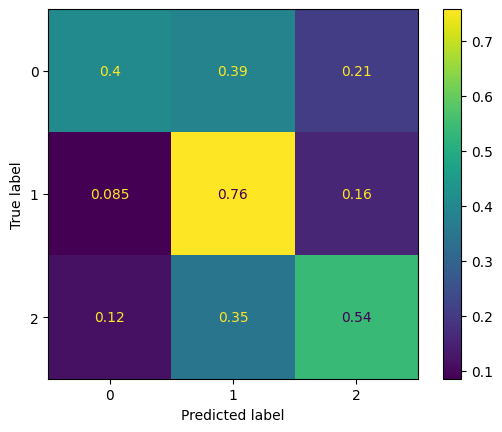

Training DeepLOBAttention...


100%|██████████| 1/1 [00:13<00:00, 13.47s/it]

model saved at all_models\DeepLOBAttention.pt
Epoch 1/1, Train Loss: 0.9654,           Validation Loss: 1.0828, Duration: 0:00:13.468242, Best Val Epoch: 0
Evaluating DeepLOBAttention...



C:\Users\bmanv\AppData\Local\Temp\ipykernel_20252\25377337.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(save_path)).to(device)


              precision    recall  f1-score   support

           0     0.5891    0.3929    0.4714     38447
           1     0.6693    0.6418    0.6553     65996
           2     0.4129    0.5954    0.4876     35100

    accuracy                         0.5616    139543
   macro avg     0.5571    0.5434    0.5381    139543
weighted avg     0.5827    0.5616    0.5624    139543



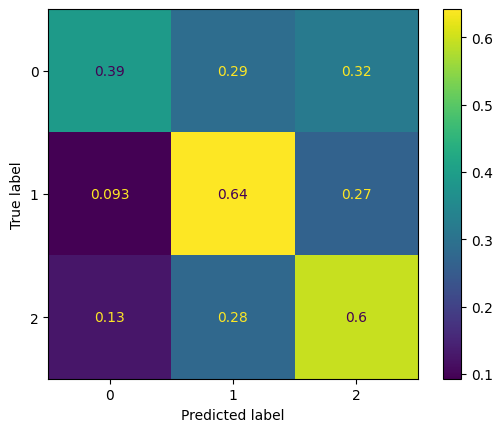

In [16]:
class FakeScheduler():
    "Class so we can call batch_gd with no scheduler"
    def step(self):
        pass

def evaluate_all(models: dict[str, nn.Module], epochs_per_model: int):
    """
    Trains each model in models on the dataset
    Modifies models in place by replacing the untrained models with the trained ones
    """
    save_dir = Path("all_models")
    save_dir.mkdir(parents=True, exist_ok=True)

    for model_name, model in models.items():

        # Train the model and save it
        print(f"Training {model_name}...")
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = FakeScheduler()

        save_path = save_dir / f"{model_name}.pt"
        batch_gd(model, criterion, optimizer, scheduler, epochs_per_model, str(save_path), force_save=True)

        # Evaluate the model
        # Load the best saved model
        print(f"Evaluating {model_name}...")
        model = torch.load(str(save_path)).to(device)
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.int64)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_predictions = np.concatenate(all_preds)
        all_targets = np.concatenate(all_labels)

        print(classification_report(all_targets, all_predictions, digits=4))

        c = confusion_matrix(all_targets, all_predictions, normalize="true")
        disp = ConfusionMatrixDisplay(c)
        disp.plot()
        plt.show()

        # Replace old model with new model
        models[model_name] = model
    
evaluate_all(models_to_test, 1)

# Run a Market Simulation

In [26]:
class BuySellDataset(data.Dataset):
    """
    Dataset to handle buying and selling simulation
    """
    def __init__(self, x, num_classes, dim, rescale_prices: bool = True):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x
        self.prices = self.compute_mid_prices(x, rescale_prices)

        self.length = x.shape[0] - T - self.dim + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.prices = torch.from_numpy(self.prices)

    def compute_mid_prices(self, x, rescale_prices: bool = True):
        """
        Compute the mid-price as the average of ask and bid prices.
        Assuming ask and bid prices are alternating in the columns.
        """
        mid_prices = []
        for i in range(x.shape[0]):
            ask_prices = x[i, 0]  # Assuming best ask is at column 1
            bid_prices = x[i, 20]  # Assuming best bid is at column 21
            mid_price = (ask_prices + bid_prices) / 2  # Calculate mid-price
            mid_prices.append(mid_price)
        mid_prices = np.array(mid_prices)
        if rescale_prices:
            mid_prices = mid_prices - np.min(mid_prices) + 0.5 # ensure price >=0.5 so no negative or 0 prices
        return mid_prices

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.prices[i]

buy_sell_dataset_test = BuySellDataset(dec_test, num_classes, dim, rescale_prices=True)
buy_sell_test_loader = torch.utils.data.DataLoader(dataset=buy_sell_dataset_test, batch_size=batch_size, shuffle=False)


# Trading Strategy Simulation
def simulate_trading_debug(preds, prices, initial_cash=10000, transaction_cost=0.001):
    cash = initial_cash
    stock = 0
    print(f"Initial cash: {cash}, transaction cost: {transaction_cost}")

    for i, (pred, price) in enumerate(zip(preds, prices)):
        if pred == 2:  # Buy signal
            num_shares = cash / (price * (1 + transaction_cost))
            cash -= num_shares * price * (1 + transaction_cost)
            stock += num_shares
            print(f"BUY at step {i}: Bought {num_shares:.2f} shares at {price:.2f}, Cash: {cash:.2f}, Stock: {stock:.2f}")
        elif pred == 0:  # Sell signal
            cash += stock * price * (1 - transaction_cost)
            print(f"SELL at step {i}: Sold {stock:.2f} shares at {price:.2f}, Cash: {cash:.2f}")
            stock = 0
        # Hold signal does nothing

    portfolio_value = cash + stock * prices[-1]
    print(f"Final Portfolio Value: {portfolio_value:.2f}, Remaining Cash: {cash:.2f}, Remaining Stock: {stock:.2f}")
    return portfolio_value

# Evaluation with Debugging
def evaluate_strategy_debug(model: nn.Module):
    """
    Given a trained model, test how well it does at trading
    """
    model.eval()
    all_preds = []
    prices_test = []
    with torch.no_grad():
        for inputs, prices in buy_sell_test_loader:
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            prices_test.append(prices.cpu().numpy())


    preds = np.concatenate(all_preds)
    prices_test = np.concatenate(prices_test)
    if len(preds) >= 10:
        print(f"Predictions: {preds[:10]} ... {preds[-10:]} (first 10 and last 10 predictions)")
    return simulate_trading_debug(preds, prices_test)

# Evaluate the model
evaluate_strategy_debug(axial_lob_model)


Predictions: [2 0 0 0 0 0 0 0 0 0] ... [1 1 1 1 1 1 1 1 1 1] (first 10 and last 10 predictions)
Initial cash: 10000, transaction cost: 0.001
BUY at step 0: Bought 5197.97 shares at 1.92, Cash: -0.00, Stock: 5197.97
SELL at step 1: Sold 5197.97 shares at 1.93, Cash: 10016.30
SELL at step 2: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 3: Sold 0.00 shares at 1.93, Cash: 10016.30
SELL at step 4: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 5: Sold 0.00 shares at 1.93, Cash: 10016.30
SELL at step 6: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 7: Sold 0.00 shares at 1.93, Cash: 10016.30
SELL at step 8: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 9: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 10: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 11: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 12: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 13: Sold 0.00 shares at 1.92, Cash: 10016.30
SELL at step 14: Sold 0.00 shares at 

0.001077021669937605

# Test on APPL Data

In [ ]:
# 11 Backtest on AAPL data from yahoo finance
import yfinance as yf

# Fetch stock data and calculate technical indicators
def fetch_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    
    # Add Returns
    df['Returns'] = df['Close'].pct_change()
    
    # Add Moving Average
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    
    # Add Exponential Moving Average
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    
    # Add Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + gain / loss))
    
    # Add MACD
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = short_ema - long_ema
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Add Bollinger Bands
    # This line throws an error for me but seemed to run before
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['MA_20'] + (2 * df['Close'].rolling(window=20).std())
    df['BB_Lower'] = df['MA_20'] - (2 * df['Close'].rolling(window=20).std())
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    return df

# Parameters for data fetch
ticker = "AAPL"  # Example: Apple stock
start_date = "2020-01-01"
end_date = "2023-01-01"

# Fetch data
data = fetch_stock_data(ticker, start_date, end_date)
print(f"Fetched {len(data)} rows of data.")

# Convert to numpy (include technical indicators)
data_np = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_10', 'EMA_10', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Lower']].to_numpy()

